In [1]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid

from sklearn.manifold import TSNE
import shap

/home/campus.ncl.ac.uk/c1014695/miniconda3/envs/pytorch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')


===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


## Model

In [3]:
batch_size = 64
num_epochs = 25
device = torch.device("cpu")
num_dimensions = 40

loss_fn = nn.BCELoss()

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(num_dimensions, 100),
            nn.ReLU(),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(100, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.unsqueeze(1).float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.unsqueeze(1).float().to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = (output > 0.5).float()  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )

model = Net().to(device)

In [4]:
model.fc_layers

Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=100, out_features=100, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.4, inplace=False)
  (11): Linear(in_features=100, out_features=100, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=100, out_features=1, bias=True)
  (15): Sigmoid()
)

In [5]:
def get_activation(model):
    activations = []

    def hook(model, input, output):
        activations.append(output.detach().numpy())

    hooks = []
    hook = model.fc_layers[12].register_forward_hook(hook)
    hooks.append(hook)
            
    return activations, hooks

## Dataset

In [6]:
encoder_epochs = 100
classes = [0,1]

class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        # Encoding from 784 (32*32) to an arbitary number of features
        self.encoder = nn.Linear(784, encoding_dim)
        # Encoding to 784 (32*32) to an arbitary number of features
        self.decoder = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        x = x.reshape(-1, 784)
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x
    
encoder = AutoEncoder(num_dimensions).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters())

mnist_trainset = datasets.MNIST(
    "Dataset",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

mnist_testset = datasets.MNIST(
    "Dataset",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

train_indices = [i for i, label in enumerate(mnist_trainset.targets) if label in classes]
test_indices = [i for i, label in enumerate(mnist_testset.targets) if label in classes]

train_subset = Subset(mnist_trainset, train_indices)
test_subset = Subset(mnist_testset, test_indices)

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False
)

def train_autoencoder(epoch):
    train_loss = 0.0

    for data in train_loader:
        images, _ = data

        images = images.view(images.size(0), -1)
        images = images.to(device)

        optimizer.zero_grad()

        outputs = encoder(images)

        loss = criterion(outputs, images)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

# Run the training and testing for defined epochs
for epoch in range(encoder_epochs):
    train_autoencoder(epoch)

Epoch: 0 	Training Loss: 3.156430
Epoch: 1 	Training Loss: 1.462921
Epoch: 2 	Training Loss: 1.243822
Epoch: 3 	Training Loss: 1.118914
Epoch: 4 	Training Loss: 1.025732
Epoch: 5 	Training Loss: 0.957434
Epoch: 6 	Training Loss: 0.910444
Epoch: 7 	Training Loss: 0.880094
Epoch: 8 	Training Loss: 0.860116
Epoch: 9 	Training Loss: 0.844725
Epoch: 10 	Training Loss: 0.817905
Epoch: 11 	Training Loss: 0.807256
Epoch: 12 	Training Loss: 0.802841
Epoch: 13 	Training Loss: 0.800252
Epoch: 14 	Training Loss: 0.797425
Epoch: 15 	Training Loss: 0.796583
Epoch: 16 	Training Loss: 0.795510
Epoch: 17 	Training Loss: 0.794831
Epoch: 18 	Training Loss: 0.793574
Epoch: 19 	Training Loss: 0.792850
Epoch: 20 	Training Loss: 0.793035
Epoch: 21 	Training Loss: 0.792647
Epoch: 22 	Training Loss: 0.792266
Epoch: 23 	Training Loss: 0.791790
Epoch: 24 	Training Loss: 0.792231
Epoch: 25 	Training Loss: 0.791789
Epoch: 26 	Training Loss: 0.791562
Epoch: 27 	Training Loss: 0.791841
Epoch: 28 	Training Loss: 0.79

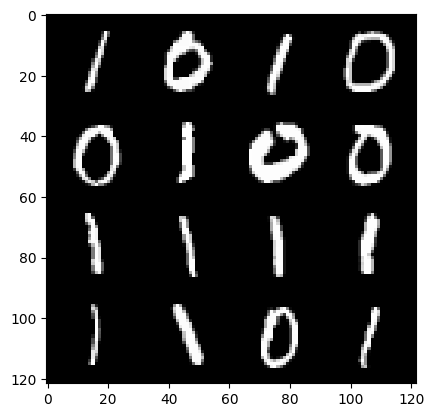

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32452396..1.357788].


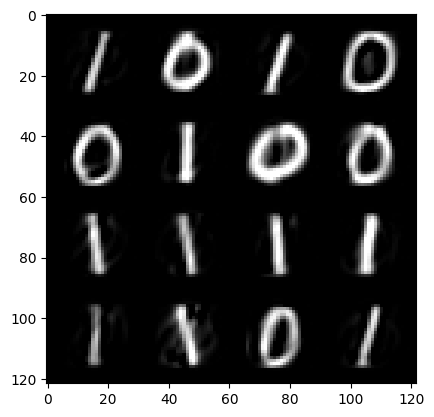

In [7]:
from torchvision.utils import make_grid


def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load 16 images from testset
inputs, _ = next(iter(test_loader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=encoder(inputs)

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)

In [8]:
def encode_dataset():
    encoder.eval()
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    with torch.no_grad():
      for data, label in train_loader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          train_features.append(encoded.to('cpu'))
          train_labels.append(label)

      for data, label in test_loader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          test_features.append(encoded.to('cpu'))
          test_labels.append(label)

    return torch.cat(train_features, dim=0), torch.cat(test_features, dim=0), torch.cat(train_labels, dim=0), torch.cat(test_labels, dim=0)

features_to_train, features_to_test, labels_to_train, labels_to_test = encode_dataset()

train_dataset = torch.utils.data.TensorDataset(features_to_train, labels_to_train)
test_dataset = torch.utils.data.TensorDataset(features_to_test, labels_to_test)

encoded_dataset_full = np.concat([features_to_train.numpy(), features_to_test.numpy()])
encoded_dataset_projections = TSNE(n_components=2, random_state=0, metric='cosine').fit_transform(encoded_dataset_full)

In [9]:
encoded_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
encoded_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Train

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, encoded_trainloader, optimizer, epoch)
    test(model, device, encoded_testloader)

Train Epoch: 1 [0/12665 (0%)]	Loss: 0.694019
Train Epoch: 1 [3200/12665 (25%)]	Loss: 0.697060
Train Epoch: 1 [6400/12665 (51%)]	Loss: 0.684847
Train Epoch: 1 [9600/12665 (76%)]	Loss: 0.696757

Test set: Average loss: 0.0110, Accuracy: 1135/2115 (54%)

Train Epoch: 2 [0/12665 (0%)]	Loss: 0.692144
Train Epoch: 2 [3200/12665 (25%)]	Loss: 0.686424
Train Epoch: 2 [6400/12665 (51%)]	Loss: 0.680635
Train Epoch: 2 [9600/12665 (76%)]	Loss: 0.684355

Test set: Average loss: 0.0106, Accuracy: 1473/2115 (70%)

Train Epoch: 3 [0/12665 (0%)]	Loss: 0.674155
Train Epoch: 3 [3200/12665 (25%)]	Loss: 0.656576
Train Epoch: 3 [6400/12665 (51%)]	Loss: 0.609671
Train Epoch: 3 [9600/12665 (76%)]	Loss: 0.542308

Test set: Average loss: 0.0057, Accuracy: 2080/2115 (98%)

Train Epoch: 4 [0/12665 (0%)]	Loss: 0.378642
Train Epoch: 4 [3200/12665 (25%)]	Loss: 0.270427
Train Epoch: 4 [6400/12665 (51%)]	Loss: 0.151748
Train Epoch: 4 [9600/12665 (76%)]	Loss: 0.140816

Test set: Average loss: 0.0009, Accuracy: 2106/2115

## SHAP

In [11]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(encoded_testloader))
images, _ = batch

background = images[:61]
test_images = images[61:64]

e = shap.DeepExplainer(model, background)

In [12]:
shap_values_train = e.shap_values(features_to_train).reshape((12665, 40))
shap_values_test = e.shap_values(features_to_test).reshape((2115, 40))
shap_values = np.concatenate((shap_values_train, shap_values_test), axis=0)
labels = np.concatenate((labels_to_train, labels_to_test), axis=0)

In [13]:
columns = [f'feature_{x}' for x in range(0,num_dimensions)]

shap_values_df = pd.DataFrame(shap_values, columns=columns)
labels_df = pd.DataFrame(labels, columns=['class'])

shap_values_df = shap_values_df.join(labels_df)
#shap_values_df.to_csv('Data/shap_values.csv', index=None)

In [14]:
shap_values_2d = TSNE(n_components=2, random_state=0, metric='cosine').fit_transform(shap_values)

In [15]:
shap_values_2d_df = pd.DataFrame(shap_values_2d, columns=['x','y']).join(labels_df)
#shap_values_2d_df.to_csv('Data/shap_values_2d.csv', index=None)

In [16]:
shap_values_2d_df.describe()

,x,y,class
count,14780.000000,14780.000000,14780.00000
mean,-0.287090,-0.016164,0.53295
std,43.749962,38.875980,0.49893
min,-89.776031,-86.832390,0.00000
25%,-35.733939,-29.132295,0.00000
50%,2.703027,1.040606,1.00000
75%,35.855805,29.980956,1.00000
max,83.295647,84.688660,1.00000


## Quick Plot

In [17]:
shap_values_2d_df = pd.read_csv('Data/shap_values_2d.csv')

In [35]:
shap_values = shap_values_2d_df = pd.read_csv('Data/shap_values_with_coordinates.csv').drop(['class'], axis = 1)

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 'class'

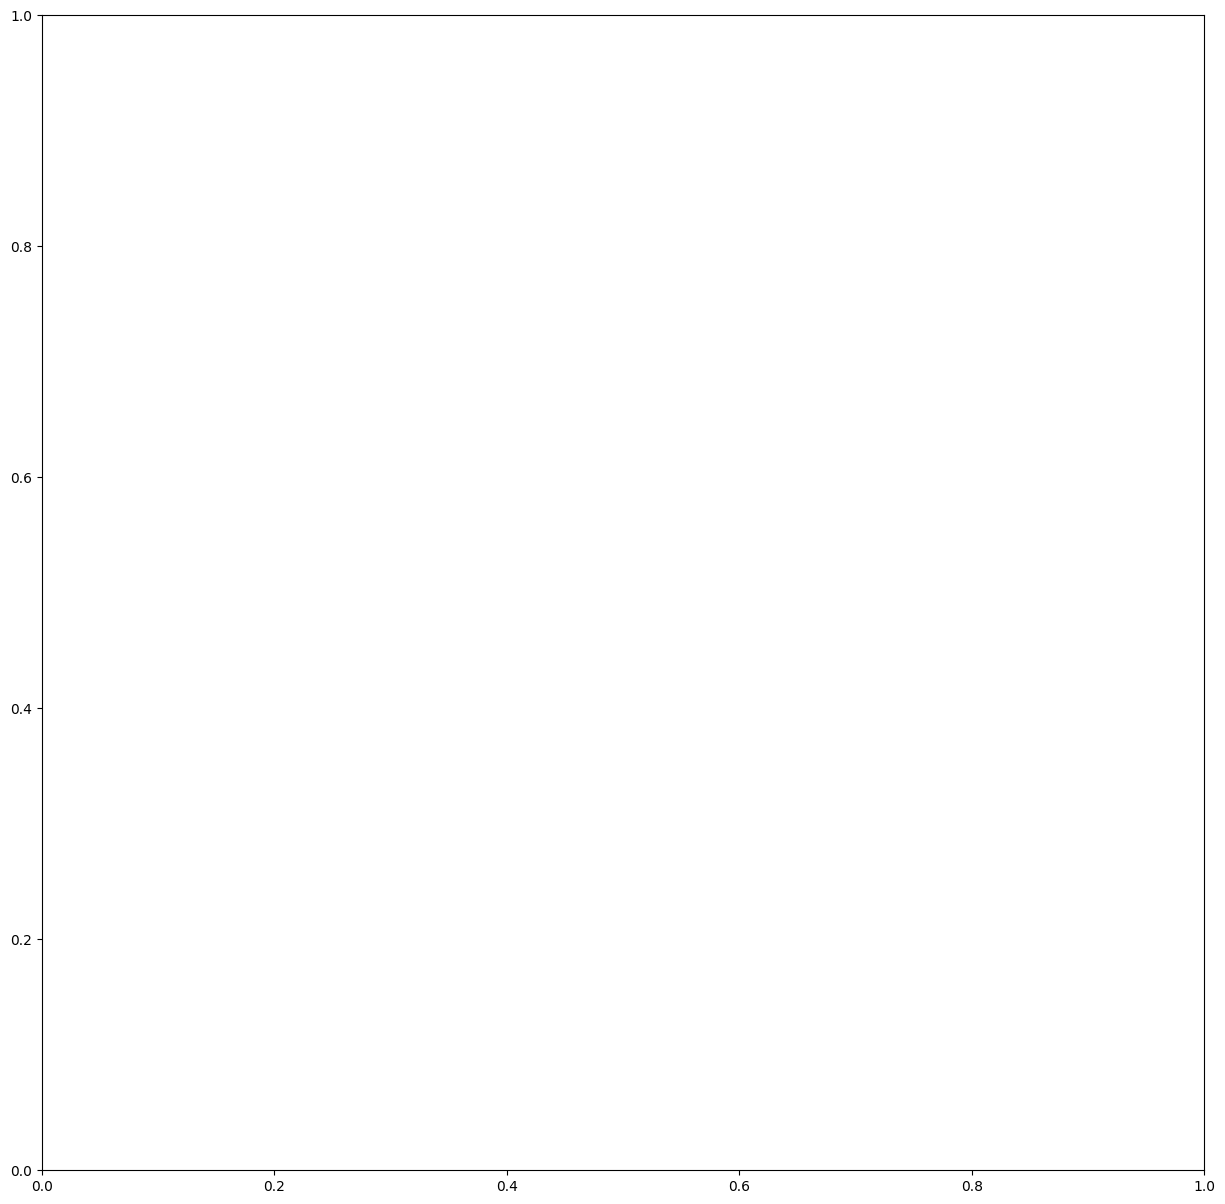

In [37]:
plt.rcParams["figure.figsize"] = [15, 15]
shap_values.plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)

## Clustering

In [54]:
clusters_1 = [
    [4,21,80,105,134,178,228,330,351,438,475,628,691,798,832,861,1029,1116,1140,1208,1294,1297,1353,1492,1514,1599,1604,1610,1693,1727,1783,1810,1952,2014,2024,2042,2045,2215,2307,2313,2335,2473,2483,2522,2545,2560,2652,2682,2739,2825,2881,2933,2934,3214,3357,3361,3372,3385,3557,3574,3579,3661,3736,3770,3805,4006,4009,4038,4052,4119,4174,4176,4248,4336,4445,4532,4643,4689,4700,4798,4828,4860,4908,4923,4950,4993,5078,5113,5129,5183,5224,5239,5255,5286,5337,5392,5426,5540,5575,5698,5771,5856,5862,5901,6028,6032,6177,6205,6316,6368,6477,6485,6507,6537,6563,6593,6641,6662,6680,6791,6888,6952,6994,7066,7145,7188,7266,7371,7524,7529,7563,7867,7886,7959,7984,8020,8038,8062,8190,8233,8239,8243,8247,8311,8314,8332,8363,8452,8547,8639,8661,8678,8810,8849,8869,8906,8920,9075,9289,9365,9505,9732,9784,9787,9803,9843,9869,9940,10002,10183,10237,10240,10350,10376,10397,10533,10574,10771,10805,10844,10905,10943,10949,10954,11051,11224,11302,11320,11401,11616,11655,11723,11759,11823,11846,11851,11924,11998,12100,12121,12128,12142,12219,12257,12326,12338,12392,12396,12402,12442,12517,12536,12614,12774,13055,13261,14051,14052,14053,14060,14061,14070,14071,14078,14183,14221,14227,14311,14323,14391,14392,14396,14401,14407,14408,14411,14557,14558,14560,14562,14567,14600,14606,14612,14700,14729,14758,14768],
    [104,157,202,343,456,651,656,791,820,1071,1242,1475,1766,1791,2065,2126,2197,2455,2585,2794,2928,3046,3194,3323,3326,3358,3455,3872,3978,4069,4151,4209,4293,4317,4360,4556,4563,4592,4639,4887,4938,4948,4960,5107,5324,5656,5811,5821,5831,5910,6018,6158,6570,6681,6813,7086,7097,7126,7385,7564,7570,7587,7723,7755,8112,8192,8236,8378,8397,8485,8526,8700,8730,8770,8983,9002,9036,9077,9169,9483,9511,9608,9621,9763,9856,9901,9960,10041,10364,10414,10660,10687,10716,10746,11284,11700,11729,11940,12042,12286,12333,12497,12509,12574,12579,12759,12802,12815,12819,12821,12862,13037,13100,13114,13231,13399,13421,13578,13637,13646,13894,14033,14632],
    [82,142,175,396,397,471,516,766,774,1232,1520,1568,1702,1813,2146,2196,2275,2312,2461,2500,2583,2601,2710,2726,3095,3230,3540,3554,3586,3793,4021,4365,4406,4484,4573,4590,4732,5062,5169,5184,5190,5312,5431,5457,5613,5633,5640,5945,5999,6399,6411,6499,6573,6679,6893,6996,7004,7357,7403,7756,7930,8074,8075,8162,8389,8415,8432,8657,8943,8953,8985,9085,9282,9317,9369,9542,9858,9975,10006,10297,10335,10406,10488,10495,10547,10631,10810,10864,11180,11241,11411,11440,11460,11516,11523,11756,11833,11911,12221,12223,12341,12491,12548,12643,12683,12792,13102,13150,13165,13208,13443,13620,14359,14442,14444,14448,14449,14452,14572,14574,14581]
]

# Clusters from a slice of 0-2500 points from the dataset 
clusters_2 = [
    [4,21,80,105,134,178,228,330,351,438,475,628,687,691,798,832,861,1029,1116,1140,1208,1294,1297,1353,1492,1514,1599,1604,1610,1693,1727,1783,1810,1952,2014,2024,2042,2045,2117,2156,2215,2307,2313,2322,2335,2473,2483],
    [35,48,96,108,158,245,252,327,341,356,436,458,490,554,558,564,592,594,607,744,782,785,787,862,865,874,916,918,946,984,1022,1030,1033,1090,1100,1103,1108,1114,1122,1131,1200,1204,1210,1263,1273,1275,1292,1335,1358,1396,1411,1425,1527,1529,1536,1541,1564,1585,1618,1625,1684,1718,1728,1772,1784,1799,1814,1833,1868,1889,1904,1927,1940,1955,2020,2059,2089,2098,2107,2211,2264,2268,2288,2309,2324,2337,2367,2386], 
    [42,71,72,85,286,322,405,463,464,915,948,991,1006,1139,1185,1258,1259,1319,1430,1544,1552,1566,1613,1655,1679,1779,1840,1878,1908,1925,1938,1957,1976,1992,2044,2079,2115,2131,2155,2163,2262,2458,2459]
]

In [55]:
cluster_num = 0
activations, hooks = get_activation(model)

for id in clusters_2[cluster_num]:
    out = model(torch.Tensor(encoded_dataset_full[id]))
activations = np.array(activations)
trans_activations = activations.transpose()

In [ ]:
shap_snip = pd.read_csv('Data/shap_values.csv').drop(['class'], axis=1)[0:2000]
top_10_entries = []
class_leaning = []
top_10_average = []
neuron_shap_vectors_m1 = [] # Method One - Vector from Top 3 SHAP values for each header across all values
neuron_shap_vectors_m2 = [] # Method Two - Vector from the SHAP values of the top 3 activations

for x in range(0,len(trans_activations)):
    top_10 = np.argsort(trans_activations[x])[-10:][::-1]
    top_10_set = top_10[0:10]
    top_10_values = trans_activations[top_10]

    top_10_average.append(np.average(top_10_values))

    top_10_entries.append(top_10_set)
    shap_values_set = shap_snip.loc[top_10_set]

    neuron_shap_vectors_m1.append([shap_values_set[col].nlargest(3).values for col in shap_snip.columns])
    neuron_shap_vectors_m2.append([shap_values_set[col].iloc[:3].values for col in shap_snip.columns ])

    classes = [labels[clusters_2[cluster_num][z]] for z in top_10_set] # CHANGE THIS VALUE DEPENDING ON THE CLUSTER
    class_leaning.append(sum(classes)/len(classes))


[[1.20402925e-01 0.00000000e+00 1.04612134e-01 1.05400912e-01
  8.27343389e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.35383543e-02 1.51350051e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.68027356e-02 0.00000000e+00 0.00000000e+00 6.56552687e-02
  1.30177677e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.03171684e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.44426733e-01 5.50373718e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 5.83107993e-02
  0.00000000e+00 1.51679724e-01 0.00000000e+00 1.10080369e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.85099044e-02
  8.86644796e-02 0.00000000e+00 5.57954088e-02]
 [8.93014550e-01 1.18677251e-01 8.28045368e-01 8.61519694e-01
  7.71393180e-01 1.08907148e-01 1.29339993e-01 1.18034959e-01
  1.05237946e-01 1.08844668e-01 6.08471692e-01 1.00746548e+00
  1.25384048e-01 1.19334489e-01 1.25525385e-01 1.26061529e-01
  5.31373620e-01 1.312

In [47]:
top_10_entries

[array([49, 45, 81, 75, 31, 50, 14, 53,  1, 86]),
 array([26, 56, 79, 12, 48, 73, 21, 32,  7, 15]),
 array([83, 54, 60, 38, 24, 17, 39, 36, 16, 11]),
 array([49, 45, 81, 75, 31, 50, 53, 14,  1, 86]),
 array([26, 56, 79, 48, 12, 73, 21, 32,  7, 43]),
 array([49, 45, 81, 75, 31, 50, 14, 53,  1, 86]),
 array([26, 56, 12, 79, 48, 73, 32, 21, 43,  7]),
 array([26, 56, 79, 12, 48, 73, 21, 32,  7, 43]),
 array([49, 45, 81, 75, 31, 50, 14, 53,  1, 86]),
 array([49, 45, 75, 81, 31, 50, 14, 53,  1, 86]),
 array([87, 86, 85, 84, 83, 82, 81, 80, 79, 78]),
 array([49, 45, 81, 75, 31, 50, 14, 53,  1, 86]),
 array([26, 56, 79, 12, 48, 73, 32, 21,  7, 43]),
 array([49, 45, 81, 75, 31, 50, 14, 53,  1, 86]),
 array([26, 56, 12, 79, 48, 73, 21, 32,  7, 43]),
 array([87, 86, 85, 84, 83, 82, 81, 80, 79, 78]),
 array([26, 56, 79, 12, 48, 73, 21, 32,  7, 43]),
 array([26, 56, 79, 12, 48, 73, 21, 32,  7, 43]),
 array([26, 56, 12, 79, 48, 73, 21, 32,  7, 15]),
 array([49, 45, 75, 31, 81,  1, 50, 53, 86, 14]),


In [48]:
similarity_matrix = []

def jacard(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

for x in range(0, len(top_10_entries)):
    similarity_scores = []
    for z in range(0, len(top_10_entries)):
        if x == z:
            similarity_scores.append(1)
        else:
            similarity_scores.append(jacard(set(top_10_entries[x]), set(top_10_entries[z])))
    similarity_matrix.append(similarity_scores)

similarity_matrix = np.array(similarity_matrix)
np.save('Matrices/cluster_one_similarity', similarity_matrix)

In [52]:
similarity_matrix

array([[1.        , 0.        , 0.        , ..., 1.        , 0.11111111,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.05263158,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.05263158,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 1.        , 0.11111111,
        1.        ],
       [0.11111111, 0.05263158, 0.05263158, ..., 0.11111111, 1.        ,
        0.11111111],
       [1.        , 0.        , 0.        , ..., 1.        , 0.11111111,
        1.        ]])

In [49]:
reduced_sim_matrix = TSNE(n_components=2, metric='cosine', random_state=0).fit_transform(similarity_matrix)

In [53]:
class_leaning_df = pd.DataFrame(class_leaning, columns=['class_association'])
average_activation_df = pd.DataFrame(top_10_average, columns=['average_activation'])
top_10_entries_df = pd.DataFrame(top_10_entries, columns=[f'activation_{x}' for x in range(0, 10)])

coordinates = pd.DataFrame(reduced_sim_matrix, columns=['x','y']).join(class_leaning_df).join(top_10_entries_df).join(average_activation_df)
coordinates

,x,y,class_association,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,average_activation
0,46.777802,-573.851074,0.0,49,45,81,75,31,50,14,53,1,86,0.762159
1,-646.566101,-168.876205,1.0,26,56,79,12,48,73,21,32,7,15,0.652215
2,395.366882,505.059479,1.0,83,54,60,38,24,17,39,36,16,11,0.400036
3,46.777802,-573.851074,0.0,49,45,81,75,31,50,53,14,1,86,0.762159
4,-433.690369,423.462280,1.0,26,56,79,48,12,73,21,32,7,43,0.663077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,416.391083,813.929749,0.9,26,56,79,49,48,12,15,73,43,84,0.535509
96,46.777802,-573.851074,0.0,49,45,81,75,31,50,14,53,1,86,0.762159
97,46.777802,-573.851074,0.0,49,45,81,75,31,50,14,53,1,86,0.762159
98,767.622131,-111.274841,0.5,87,86,85,84,83,82,81,80,79,78,0.951734


<Axes: xlabel='x', ylabel='y'>

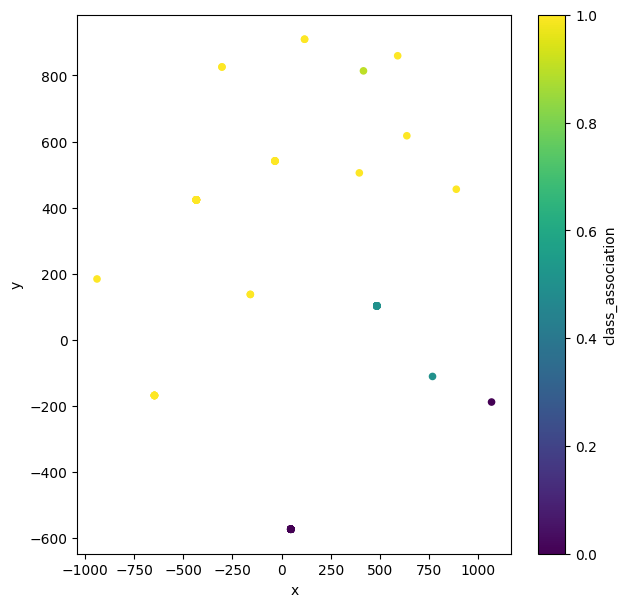

In [51]:
plt.rcParams["figure.figsize"] = [7,7]

coordinates.plot.scatter(
    x='x',
    y='y',
    c='class_association'
)